 # <font color = #254117>[EEP 147]: ESG Analysis</font>

<div style="width:image width px; font-size:80%; text-align:center;"><img src="big_creek.jpg" alt="alternate text" width="500" height="height" style="padding-bottom:0.5em;" />Big Creek Hydroelectric Project - Southern California Edison</div>

This notebook expands upon the concepts used in the tutorial notebook and can be utilized for analysis of rounds in the Electricity Strategy Game. Any of the following code can be changed to create new or different visualizations, but as is, running through the cells will allow you to visualize and calculate the profit that your plants have generated in a given hour.

**Note:** This notebook does not currently take into account any loans, interest payments, or carbon credits, and is simply an evaluation of the individual hour you are examining.

First on our agenda is to import **<font color = ##008700>dependencies</font>** -- packages in Python that add to the basic functions in Python -- same as before.

In [82]:
from datascience import *
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
plt.style.use('fivethirtyeight')

Next, let's select your portfolio. In the cell below, assign **section** to the section number that corresponds to your own according to the following table.

| Number | Section Time  |
|---------|---------------|
| 1 | Wednesday 8am |
| 2 | Friday 2pm |
| 3 | Wednesday 9am |
| 4 | Friday 4pm |

Assign **YOUR_PORTFOLIO** to the name of your portfolio from the following choices:

**'Bay Views',
 'Beachfront',
 'Big Coal',
 'Big Gas',
 'East Bay',
 'Fossil Light',
 'Old Timers'**
 
The variable, **demand**, should be set to the quantity demanded by the market for the given hour, and finally set **hour** to the hour (1-4) that you want to be examining. You can change these at any time, just be sure to rerun all cells after you make changes here.

In [83]:
section = 1
YOUR_PORTFOLIO = "Big Gas"
period = 2
hour = 3
permit_price = 100

Next we import the demand realizations (for past rounds) and forecasts (for future rounds) and assign the current demand.

In [84]:
demand_table = Table.read_table('demand.csv')
demand = demand_table.where("round", period).where("hour", hour)["load"].item()
print(demand)

19500.0


Next we import our tables, one for each discussion section, and one with individualized information about our plants.

In [85]:
bids_0 = Table.read_table('MC_bids.csv').sort('PORTFOLIO')
bids_1 = Table.read_table('S1_bids_' + str(period) + '.csv').sort('PORTFOLIO')
bids_2 = Table.read_table('S2_bids_' + str(period) + '.csv').sort('PORTFOLIO')
bids_3 = Table.read_table('S3_bids_' + str(period) + '.csv').sort('PORTFOLIO')
bids_4 = Table.read_table('S4_bids_' + str(period) + '.csv').sort('PORTFOLIO')
ESG = Table.read_table('ESGPorfolios_forcsv.csv')

The table below should now display the names and bids that your team and others in your discussion section assigned for each individual plant.

In [86]:
bids = globals()['bids_' + str(section)]
if section > 0:
    bids = bids.where("PERIOD", period)
bids.show()

TEAM,TEAM_ID,PORTFOLIO,PORTFOLIO_ID,PLANT,PLANT_ID,PERIOD,PRICE1,PRICE2,PRICE3,PRICE4
Debreu,4,Bay_Views,3,MORRO_BAY_1-2,31,2,40,38.78,38.78,38.78
Debreu,4,Bay_Views,3,MORRO_BAY_3-4,32,2,40,36.61,36.61,36.61
Debreu,4,Bay_Views,3,MOSS_LANDING_6,33,2,40,32.56,32.56,32.56
Debreu,4,Bay_Views,3,MOSS_LANDING_7,34,2,40,32.56,32.56,32.56
Debreu,4,Bay_Views,3,OAKLAND,35,2,61.17,61.17,61.17,61.17
Arrow,1,Beachfront,4,COOLWATER,41,2,42.39,42.39,42.39,42.39
Arrow,1,Beachfront,4,ETIWANDA_1-4,42,2,42.67,42.67,42.67,42.67
Arrow,1,Beachfront,4,ETIWANDA_5,43,2,62.89,62.89,62.89,62.89
Arrow,1,Beachfront,4,ELLWOOD,44,2,75.61,75.61,75.61,75.61
Arrow,1,Beachfront,4,MANDALAY_1-2,45,2,39.06,39.06,39.06,39.06


Recall the table ESG, which we used in the introductory notebook.  Let's add in the permit cost per MWH using the permit price. This is just the tons per MWH times the permit price.  We can add this to variable cost to get a new total variable cost.  The first few rows are shown below.

In [87]:
ESG["Permit_Cost_USDperMWH"] = permit_price * ESG.column("Carbon_tonsperMWH")
ESG["Var_Cost_USDperMWH"] =  ESG.column("Total_Var_Cost_USDperMWH") +  ESG.column("Permit_Cost_USDperMWH")
ESG.show(5)

Group,Group_num,UNIT NAME,Capacity_MW,Heat_Rate_MMBTUperMWh,Fuel_Price_USDperMMBTU,Fuel_Cost_USDperMWH,Var_OandM_USDperMWH,Total_Var_Cost_USDperMWH,Carbon_tonsperMWH,FixedCst_OandM_perDay,Plant_ID,Permit_Cost_USDperMWH,Var_Cost_USDperMWH
Big Coal,1,FOUR CORNERS,1900,11.67,3,35,1.5,36.5,1.1,"$8,000",11,110,146.5
Big Coal,1,ALAMITOS 7,250,16.05,4.5,72.22,1.5,73.72,0.85,$0,12,85,158.72
Big Coal,1,HUNTINGTON BEACH 1&2,300,8.67,4.5,39,1.5,40.5,0.46,"$2,000",13,46,86.5
Big Coal,1,HUNTINGTON BEACH 5,150,14.44,4.5,65,1.5,66.5,0.77,"$2,000",14,77,143.5
Big Coal,1,REDONDO 5&6,350,8.99,4.5,40.44,1.5,41.94,0.48,"$3,000",15,48,89.94


We will need both of these tables to generate an analysis of how our round went, so in the following cell we will join the tables based on the column **Plant_ID**:

In [88]:
sorted_joined_table = bids.join("PLANT_ID", ESG, "Plant_ID").sort("PRICE" + str(hour), descending = False)
sorted_joined_table.show(5)

PLANT_ID,TEAM,TEAM_ID,PORTFOLIO,PORTFOLIO_ID,PLANT,PERIOD,PRICE1,PRICE2,PRICE3,PRICE4,Group,Group_num,UNIT NAME,Capacity_MW,Heat_Rate_MMBTUperMWh,Fuel_Price_USDperMMBTU,Fuel_Cost_USDperMWH,Var_OandM_USDperMWH,Total_Var_Cost_USDperMWH,Carbon_tonsperMWH,FixedCst_OandM_perDay,Permit_Cost_USDperMWH,Var_Cost_USDperMWH
61,Heckman,6,Old_Timers,6,BIG_CREEK,2,0,0,0,0,Old Timers,7,BIG CREEK,1000,nan,0,0,0,0,0,"$15,000",0,0
72,Krugman,7,Low_Fossil,7,HELMS,2,0.5,0.5,0.5,0.5,Fossil Light,8,HELMS,800,nan,0,0,0.5,0.5,0,"$15,000",0,0.5
75,Krugman,7,Low_Fossil,7,DIABLO_CANYON_1,2,11.5,11.5,11.5,11.5,Fossil Light,8,DIABLO CANYON 1,1000,1,7.5,7.5,4,11.5,0,"$20,000",0,11.5
33,Debreu,4,Bay_Views,3,MOSS_LANDING_6,2,40,32.56,32.56,32.56,Bay Views,4,MOSS LANDING 6,750,6.9,4.5,31.06,1.5,32.56,0.37,"$8,000",37,69.56
34,Debreu,4,Bay_Views,3,MOSS_LANDING_7,2,40,32.56,32.56,32.56,Bay Views,4,MOSS LANDING 7,750,6.9,4.5,31.06,1.5,32.56,0.37,"$8,000",37,69.56


Great! Now we have a table that has our bids for this round as well as information about the capacity of our plants as well as their marginal cost of production. Now we can continue and make plots similar to those in the introductory notebook, that will allow us to examine how we performed in this given hour. Run the following series of cells to generate a legend as well as a plot of plant capacity versus plant bid price, with bids ordered from least to greatest.

In [89]:
def find_x_pos(widths):
    cumulative_widths = [0]
    cumulative_widths.extend(np.cumsum(widths))
    half_widths = [i/2 for i in widths]
    x_pos = []
    for i in range(0, len(half_widths)):
        x_pos.append(half_widths[i] + cumulative_widths[i])
    return x_pos


In [90]:
width = sorted_joined_table.column("Capacity_MW")
width
height = sorted_joined_table.column('PRICE' + str(hour))
height
new_x = find_x_pos(width)

In [91]:
energy_colors_dict = {}
count = 0
colors = ['#EC5F67', '#F29056', '#F9C863', '#99C794', '#5FB3B3', '#6699CC', '#C594C5']
for i in set(sorted_joined_table['Group']):
    energy_colors_dict[i] = colors[count]
    count += 1

In [92]:
colors_mapped = list(pd.Series(sorted_joined_table['Group']).map(energy_colors_dict))
sorted_joined_table = sorted_joined_table.with_column('Color', colors_mapped)

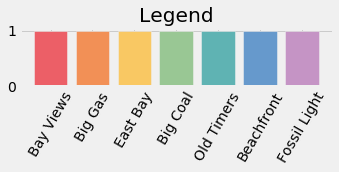

In [93]:
plt.figure(figsize=(5,1))
plt.bar(energy_colors_dict.keys(), 1, color = energy_colors_dict.values())
plt.xticks(rotation=60)
plt.title('Legend')
plt.show()

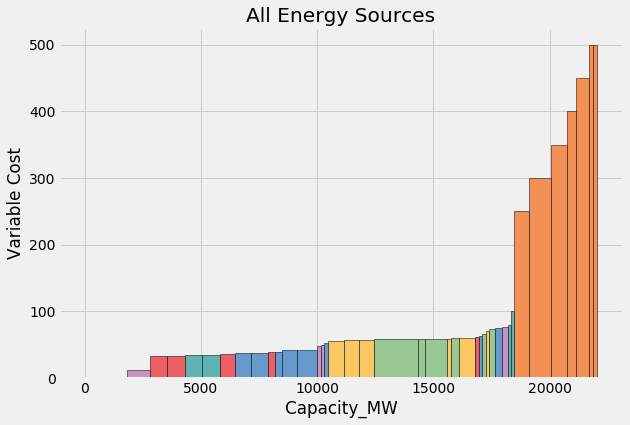

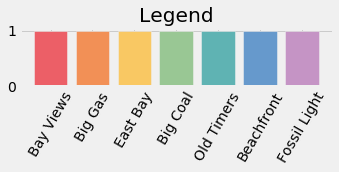

In [94]:
# Make the plot
plt.figure(figsize=(9,6))
plt.bar(new_x, height, width=width, color=sorted_joined_table['Color'], edgecolor = "black")
#plt.xticks(y_pos, bars)
# Add title and axis names
plt.title('All Energy Sources')
plt.xlabel('Capacity_MW')
plt.ylabel('Variable Cost')

plt.show()

plt.figure(figsize=(5,1))
plt.bar(energy_colors_dict.keys(), 1, color = energy_colors_dict.values())
plt.xticks(rotation=60)
plt.title('Legend')
plt.show()

Now we can examine the plot above to determine our market price using the capacity demanded that we entered at the top of this notebook.

In [95]:
def price_calc(demand, sorted_table):
    price = 0
    sum_cap = 0
    for i in range(0,len(sorted_table['Capacity_MW'])):
        if sum_cap + sorted_table['Capacity_MW'][i] > demand:
            price = sorted_table['PRICE' + str(hour)][i]
            break
        else:
            sum_cap += sorted_table['Capacity_MW'][i]
            price = sorted_table['PRICE' + str(hour)][i]
    return price

In [96]:
def price_line_plot(price):
    plt.axhline(y=price, color='r', linewidth = 2)
    print("Price: " + str(price))

In [97]:
def demand_plot(demand):
    plt.axvline(x=demand, color='r', linewidth = 2)
    print("Capacity: " + str(demand))

Hour: 3
Price: 300.0
Capacity: 19500.0


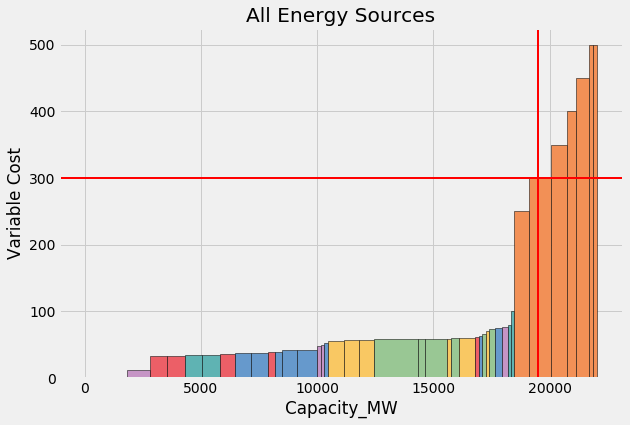

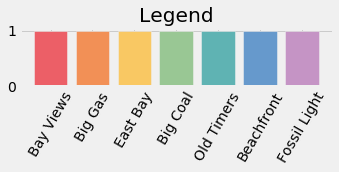

In [98]:
# Make the plot
price = price_calc(demand, sorted_joined_table)
plt.figure(figsize=(9,6))
plt.bar(new_x, height, width=width, color=sorted_joined_table['Color'], edgecolor = "black")
plt.title('All Energy Sources')
plt.xlabel('Capacity_MW')
plt.ylabel('Variable Cost')

print('Hour: ' + str(hour))
price_line_plot(price)
demand_plot(demand)

plt.show()

plt.figure(figsize=(5,1))
plt.bar(energy_colors_dict.keys(), 1, color = energy_colors_dict.values())
plt.xticks(rotation=60)
plt.title('Legend')
plt.show()

Finally, we have a market price. Let us construct the same plot, but this time only considering the plants that are part of our portfolio.

In [99]:
your_source = sorted_joined_table.where("Group", YOUR_PORTFOLIO)
width_yours = your_source.column("Capacity_MW")
height_yours = your_source.column('PRICE' + str(hour))
height_yours_marginal_cost = your_source.column("Var_Cost_USDperMWH")
new_x_yours = find_x_pos(width_yours)
label_yours = your_source.column("PLANT")

Price: 300.0


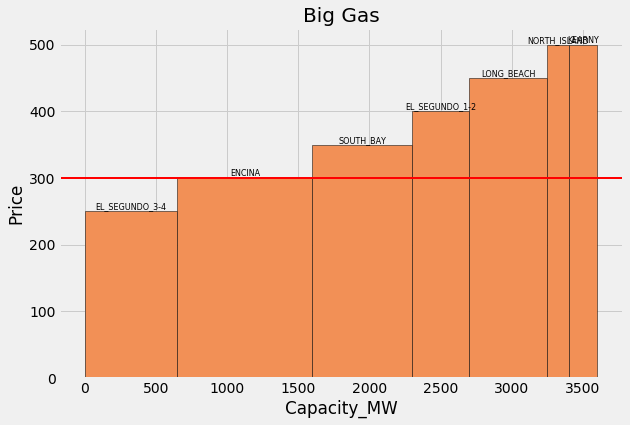

In [100]:
# Make the plot
plt.figure(figsize=(9,6))
plt.bar(new_x_yours, height_yours, width=width_yours, color = energy_colors_dict[YOUR_PORTFOLIO], edgecolor = "black")
plt.title(YOUR_PORTFOLIO)
plt.xlabel('Capacity_MW')
plt.ylabel('Price')
for new_x_i, height_i, label_i in zip(new_x_yours, height_yours, label_yours):
    plt.text(new_x_i, height_i, label_i,
                ha='center', va='bottom', fontsize=8)
price_line_plot(price)

plt.show()

Let's reduce our problem further to only include the plants that are actually operational under the new market price. Run the following cell to see the plants that will operate given our market price, and then we can begin the process of calculating our profit.

Price: 300.0


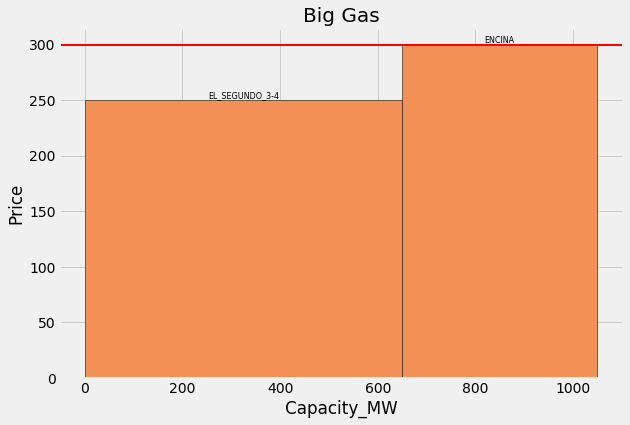

In [101]:
nonmarg_capacity = sum(sorted_joined_table.where('PRICE' + str(hour), are.below(price))["Capacity_MW"])
marg_capacity = sum(sorted_joined_table.where('PRICE' + str(hour), are.equal_to(price))["Capacity_MW"])
marg_demand = demand - nonmarg_capacity
marg_proportion = marg_demand / marg_capacity

marginal_plants = np.where(height_yours == price)[0]
width_yours2 = width_yours.copy()
width_yours2[marginal_plants] = width_yours2[marginal_plants] * marg_proportion
new_x_yours2 = find_x_pos(width_yours2)


plt.figure(figsize=(9,6))
num_x = len(your_source.where('PRICE' + str(hour), are.below_or_equal_to(price))[1])
plt.bar(new_x_yours2[:num_x], height_yours[:num_x], width=width_yours2[:num_x], 
        color = energy_colors_dict[YOUR_PORTFOLIO],
        edgecolor = "black")
plt.title(YOUR_PORTFOLIO)
plt.xlabel('Capacity_MW')
plt.ylabel('Price')
for new_x_i, height_i, label_i in zip(new_x_yours2[:num_x], height_yours[:num_x], label_yours[:num_x]):
    plt.text(new_x_i, height_i, label_i,
                ha='center', va='bottom', fontsize=8)
price_line_plot(price)


plt.show()

The plot above allows us to see how the prices we have set correspond to the market price. However, in order to look at the profits that we are making, we should look at our marginal cost rather than our bid prices. We do this in the plot below, allowing us to compare the market price of energy in this hour to the marginal costs for running the plants that have a bid price that was below the market price. We should include the permit price in marginal cost: even if we are grandfathered permits, the ability to sell the permits represents an opportunity cost.

Price: 300.0


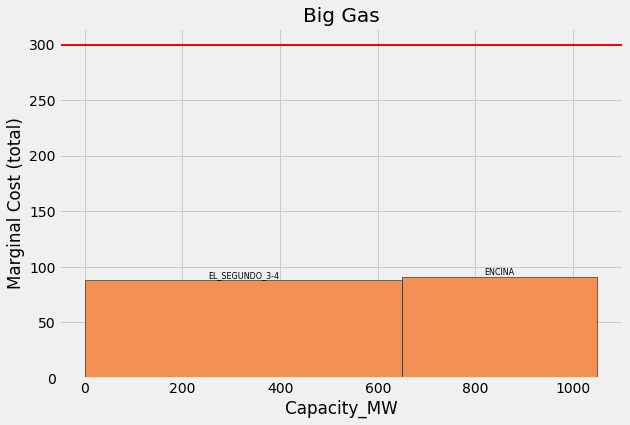

In [102]:
plt.figure(figsize=(9,6))
num_x = len(your_source.where('PRICE' + str(hour), are.below_or_equal_to(price))[1])
plt.bar(new_x_yours2[:num_x], height_yours_marginal_cost[:num_x], width=width_yours2[:num_x], 
        color = energy_colors_dict[YOUR_PORTFOLIO],
        edgecolor = "black")
plt.title(YOUR_PORTFOLIO)
plt.xlabel('Capacity_MW')
plt.ylabel('Marginal Cost (total)')
for new_x_i, height_i, label_i in zip(new_x_yours2[:num_x], height_yours_marginal_cost[:num_x], label_yours[:num_x]):
    plt.text(new_x_i, height_i, label_i,
                ha='center', va='bottom', fontsize=8)
price_line_plot(price)

plt.show()

Now we can finally calculate profit. The graphic above should show the market price line along with the marginal costs for operating our plants. Thus we can calculate profit by calculating the area between the red line and the blue boxes, as that will give us the total revenue - total cost. The function defined below is designed to perform that calculation.

In [103]:
def profit(sorted_table, price):
    capacity_subset = sum(sorted_table.where('PRICE' + str(hour), are.below(price))["Capacity_MW"])
    capacity_subset += sum(sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Capacity_MW"] * marg_proportion)
    revenue = capacity_subset * price
    cost = 0
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.below(price))["Var_Cost_USDperMWH"])):
        cost += sorted_table.where('PRICE' + str(hour), are.below(price))["Var_Cost_USDperMWH"][i]\
        * sorted_table.where('PRICE' + str(hour), are.below(price))["Capacity_MW"][i]
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Var_Cost_USDperMWH"])):
        cost += sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Var_Cost_USDperMWH"][i]\
        * (sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Capacity_MW"][i] * marg_proportion)
    return revenue - cost

def profit_pab(sorted_table, price):
    revenue = 0
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.below(price))['PRICE' + str(hour)])):
        revenue += sorted_table.where('PRICE' + str(hour), are.below(price))['PRICE' + str(hour)][i]\
        * sorted_table.where('PRICE' + str(hour), are.below(price))["Capacity_MW"][i]
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.equal_to(price))['PRICE' + str(hour)])):
        revenue += sorted_table.where('PRICE' + str(hour), are.equal_to(price))['PRICE' + str(hour)][i]\
        * (sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Capacity_MW"][i] * marg_proportion)
    cost = 0
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.below(price))["Var_Cost_USDperMWH"])):
        cost += sorted_table.where('PRICE' + str(hour), are.below(price))["Var_Cost_USDperMWH"][i]\
        * sorted_table.where('PRICE' + str(hour), are.below(price))["Capacity_MW"][i]
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Var_Cost_USDperMWH"])):
        cost += sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Var_Cost_USDperMWH"][i]\
        * (sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Capacity_MW"][i] * marg_proportion)
    return revenue - cost

In [104]:
profit(your_source, price)

221389.0

We can now calculate the number of permits used.

In [105]:
def permits(sorted_table, price):
    permits = 0
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.below(price))["Var_Cost_USDperMWH"])):
        permits += sorted_table.where('PRICE' + str(hour), are.below(price))["Carbon_tonsperMWH"][i]\
        * sorted_table.where('PRICE' + str(hour), are.below(price))["Capacity_MW"][i]
    for i in range(len(sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Var_Cost_USDperMWH"])):
        permits += sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Carbon_tonsperMWH"][i]\
        * (sorted_table.where('PRICE' + str(hour), are.equal_to(price))["Capacity_MW"][i] * marg_proportion)
    return permits

In [108]:
permits(your_source, price)

501.5

We now have the ability to estimate the amount of profit our plants will generate based on a given amount of demand! Again, this does not include considerations of credit or carbon emmissions, but it should give you a general sens of how your plants performed for this hour. Try going back to the start of the notebook and changing the hour you are examining, or add more cells to do a deeper analysis of your performance on your own to make better decisions for your team in the future.

# Conclusion and Resources

Congratulations! You have completed your Jupyter Notebook for the ESG. If you have questions, please do not hesitate to post them on the dedicated Piazza thread (https://piazza.com/class/jr2lknh4q311x1?cid=41).

Module Developers: Alec Kan, Alma Pineda, Aarish Irfan, Elaine Chien, and Octavian Sima.

Data Science Modules: http://data.berkeley.edu/education/modules